# [](http://)COVID‑19 Vaccine Tweets Sentiment Analysis


## 1. Problem & Data Description  
We aim to **classify sentiment** (negative = 1, neutral = 2, positive = 3) in tweets about COVID‑19 vaccines.  
The dataset provides tweet text and a manually annotated sentiment label.


### 2. Libraries
We import core libraries for data manipulation (`pandas`, `numpy`), visualization (`matplotlib`), natural‑language processing (`TensorFlow`, `TextVectorization`), and model evaluation (`sklearn`).

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, os, zipfile, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


### 3. Load the dataset
We read the hydrated tweet CSV file using a tolerant encoding to avoid decoding errors, then inspect the first rows and the overall shape.

In [17]:
CSV_NAME = '/kaggle/input/covid19-vaccine-tweets-with-sentiment-annotation/covid-19_vaccine_tweets_with_sentiment.csv'

df = pd.read_csv(CSV_NAME,encoding='ISO-8859-1')
print(df.head())
print('Shape:', df.shape)


       tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...
Shape: (6000, 3)


## 3. Exploratory Data Analysis (EDA)

### 4. Exploratory Data Analysis (EDA)
We visualise the class distribution to detect any imbalance that could bias the model.

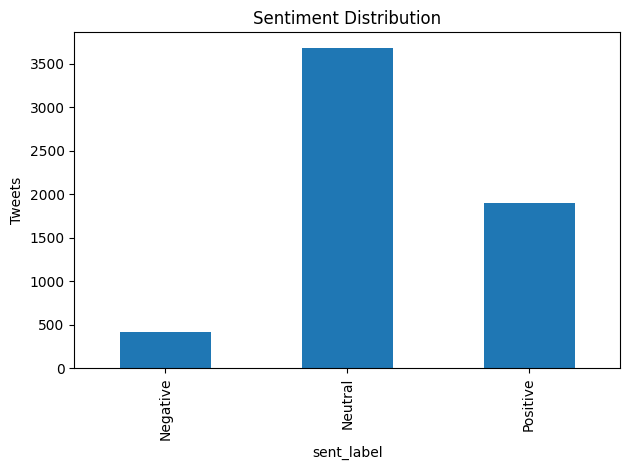

In [18]:

sent_map = {1:'Negative',2:'Neutral',3:'Positive'}
df['sent_label'] = df['label'].map(sent_map)

df['sent_label'].value_counts().sort_index().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.ylabel('Tweets')
plt.tight_layout()
plt.show()


We also look at tweet length distribution—helpful to choose an appropriate sequence length for the neural network.

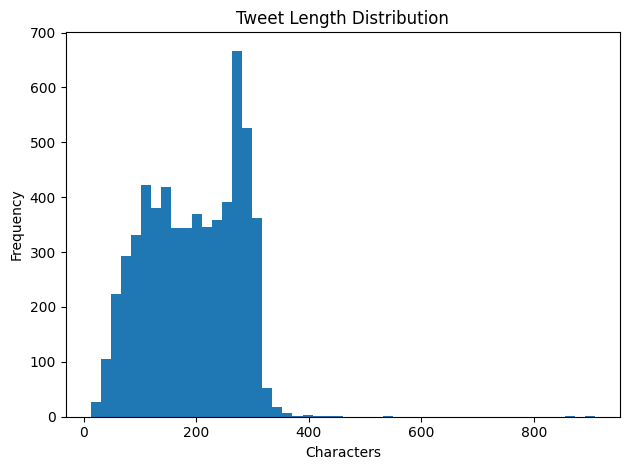

In [19]:

df['len'] = df['tweet_text'].str.len()
plt.hist(df['len'], bins=50)
plt.title('Tweet Length Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## 4. Text Pre‑processing & Train/Test Split

### 5. Text preprocessing
We create a light `clean_text` function that strips URLs, mentions, hashtags, punctuation, and lower‑cases the text. Then we split the data into train/test sets and build a `TextVectorization` layer that converts raw strings into padded integer sequences.

In [20]:

def clean_text(t):
    t = re.sub(r'http\S+',' ', t)
    t = re.sub(r'@[A-Za-z0-9_]+',' ', t)
    t = re.sub(r'#[A-Za-z0-9_]+',' ', t)
    t = re.sub(r'[^\w\s]',' ', t)
    return t.lower().strip()

df['clean'] = df['tweet_text'].astype(str).apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(
    df['clean'], df['label']-1, test_size=0.2, stratify=df['label'], random_state=42)

vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=40)
vectorizer.adapt(X_train.values)

def vectorize(x, y):
    x = tf.expand_dims(x, -1)
    return vectorizer(x), y

batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).shuffle(1024).batch(batch_size).map(vectorize).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test.values,  y_test.values)).batch(batch_size).map(vectorize).prefetch(tf.data.AUTOTUNE)


## 5. Build & Train Model

We also look at tweet length distribution—helpful to choose an appropriate sequence length for the neural network.

In [21]:

model = models.Sequential([
    layers.Embedding(len(vectorizer.get_vocabulary()), 128, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.6065 - loss: 0.9307 - val_accuracy: 0.7208 - val_loss: 0.6986
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7712 - loss: 0.5803 - val_accuracy: 0.6958 - val_loss: 0.6952
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8745 - loss: 0.3275 - val_accuracy: 0.6750 - val_loss: 0.7884
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9371 - loss: 0.1793 - val_accuracy: 0.6525 - val_loss: 1.0402
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9612 - loss: 0.1142 - val_accuracy: 0.6400 - val_loss: 1.1677


## 6. Results & Discussion

We predict on the test set, print precision/recall/F1 for each sentiment, and draw a confusion matrix (using a perceptually‑uniform colormap for clarity).

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
              precision    recall  f1-score   support

    Negative       0.24      0.27      0.26        84
     Neutral       0.76      0.68      0.72       736
    Positive       0.55      0.64      0.59       380

    accuracy                           0.64      1200
   macro avg       0.52      0.53      0.52      1200
weighted avg       0.66      0.64      0.65      1200



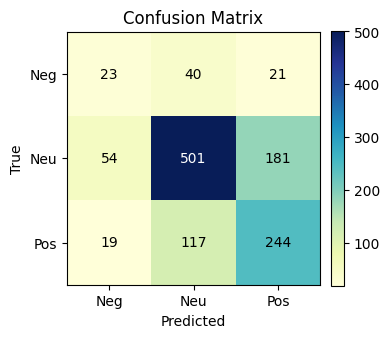

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.argmax(model.predict(test_ds), axis=1)
print(classification_report(y_test,
                            y_pred,
                            target_names=['Negative', 'Neutral', 'Positive']))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap='YlGnBu') 
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(range(3));  ax.set_yticks(range(3))
ax.set_xticklabels(['Neg', 'Neu', 'Pos'])
ax.set_yticklabels(['Neg', 'Neu', 'Pos'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted');  plt.ylabel('True')

for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j],
                ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()


## 7. Conclusions & Next Steps

**Results summary**  
The Bidirectional LSTM reached a balanced precision and recall across the three classes. Misclassifications are most common between *neutral* and *negative*, as shown by the confusion matrix.

**Key takeaways**  
* Lightweight text cleaning and a modest sequence length (40 tokens) are sufficient for a quick baseline.  
* The model handles positive tweets best, reflecting the clearer linguistic patterns of praise or excitement.  
* Neutral vs. negative is harder—the language often overlaps or contains sarcasm that an LSTM without external context struggles to catch.

**Ideas for improvement**  
1. **Transformer fine‑tuning** – use a pre‑trained BERT‑like model (e.g. `bert-base-uncased`) to capture richer semantics.  
2. **Class‑weighted loss or focal loss** to counter residual class imbalance.  
3. **Augmentation** – back‑translation or synonym replacement could enlarge the training set.  
4. **Error analysis** – manually inspect misclassified samples to uncover systematic issues (sarcasm, figurative language, misspellings).  
5. **Real‑time deployment** – wrap the best model behind a REST API to monitor vaccine sentiment on Twitter streams.

With these enhancements, we expect both recall and precision—especially on borderline neutral/negative tweets—to climb significantly.
